In [1]:
import logging, sys
LOG_LEVEL = logging.ERROR
logging.basicConfig(filename='current.log',encoding='utf-8',level=LOG_LEVEL, filemode = 'w', format='%(process)d-%(levelname)s-%(message)s')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))

In [2]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

## Check if Tensorflow really runs on your GPU
# refer first to the README (!), then to this article, especially if you are using a windows machine https://www.tensorflow.org/install/pip#windows-wsl2_1
#tf_config = tf.config.list_physical_devices('GPU')
#logging.debug("Num GPUs Available: {}".format(len(tf.config.list_physical_devices('GPU'))))
#logging.debug(tf_config)
    
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    #tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    tf.config.experimental.set_memory_growth(gpus[0], True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    logging.debug((len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs"))
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    logging.debug(e)


2024-03-28 10:42:59.427854: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-28 10:43:00.110985: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 10:43:01.514213: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-03-28 10:43:04.463422: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 10:43:

In [3]:
from skimage import exposure, io
from flowdec import data as tfd_data
from flowdec import psf as tfd_psf
from flowdec import restoration as tfd_restoration
from skimage.transform import rescale
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
import numpy as np
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
#Microscope Parameters aka PSF
# # Image properties
# # Size of the PSF array, pixels
size_x = 256
size_y = 256
size_z = 128
#
# # Microscope parameters
NA          = 0.9
wavelength  = 0.588 # microns
M           = 100   # magnification
ns          = 1.0  # specimen refractive index (RI)
ng0         = 1.0   # coverslip RI design value
ni0         = 1.0   # immersion medium RI design value
ti0         = 3000   # microns, working distance (immersion medium thickness) design value
tg0         = 0   # microns, coverslip thickness design value
res_lateral = 0.075   # microns
res_axial   = 0.25  # microns

# ng          = 1.5   # coverslip RI experimental value (defaults to ng0 if not given)
# ni          = 1.5   # immersion medium RI experimental value (defaults to ni0 if not given)
# tg          = 170   # microns, coverslip thickness experimental value
# pZ          = 2     # microns, particle distance from coverslip
#
# # Precision control
# num_basis    = 100  # Number of rescaled Bessels that approximate the phase function
# num_samples  = 1000 # Number of pupil samples along radial direction
# oversampling = 2    # Defines the upsampling ratio on the image space grid for computations

In [5]:
# Set directory of image stack
# sudo mount -t drvfs '//samba-pool-pool-plitzko3.biochem.mpg.de/pool-plitzko3' /mnt/plitzko3
file_pattern = "/mnt/plitzko3/Johann/03-Data/04-LightMicroscopy/230324_FF_Ape1_Atg8_Box1_Grid1/FOV1.ome.tif"#"/mnt/plitzko3/Johann/test_adrian/stack_10.tif"#'/mnt/plitzko3/Adrian/YeastData/YeastDataset2/FLM_stacks/stack_10.tiff'
logging.info("Current File: {}".format(file_pattern))

In [6]:
# Load image stack
stack = io.imread(file_pattern, plugin="tifffile")
logging.info(stack.shape)
logging.info(stack.dtype)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/plitzko3/Johann/03-Data/04-LightMicroscopy/230324_FF_Ape1_Atg8_Box1_Grid1/FOV1.ome.tif'

In [ ]:
scalexy, scalez = 1, 1
if np.max(scalexy) == 1 and np.max(scalez) == 1:
    stack_scaled = stack
else:
    stack_scaled = rescale(stack, (scalez,scalexy,scalexy), mode='constant', order=2, anti_aliasing=True) 
logging.info(stack_scaled.shape)

In [ ]:
# This is meant to be representative of a 60x widefield image capture (all distance units are in microns)
psf = np.zeros_like(stack_scaled)
psf = tfd_psf.GibsonLanni(
    na=NA,           # Numerical aperture
    m=M,             # Magnification
    ni0=ni0,         # Immersion RI
    res_lateral=res_lateral, # X/Y resolution
    res_axial=res_axial,     # Axial resolution
    wavelength=wavelength,  # Emission wavelength 
    size_x=np.max((size_x, int(stack_scaled.shape[2]))), 
    size_y=np.max((size_y, int(stack_scaled.shape[1]))), 
    size_z=np.min((size_z, int(stack_scaled.shape[0]))),
    ns = ns,
    ng0 = ng0,
    ti0 = ti0,
    tg0 = tg0,
).generate()
logging.debug((psf.shape, psf.dtype))

In [ ]:
imgs = []
scores = {}
def observer(img, i, *args):
    imgs.append(img)
    scores[i] = {
    'mse': mean_squared_error(stack_scaled, img),
    #'ssim': structural_similarity(stack_scaled, img, data_range=1), #@TODO find out why SSIM doesn't work as expected
    'psnr': peak_signal_noise_ratio(stack_scaled, img)
    }
    
    if i % 5 == 0:
        if i == 5:
            logging.info('Observing iteration = {} (dtype = {}, max = {:.3f})'.format(i, img.dtype, img.max()))        
        else:            
            #logging.info('Observing iteration = {} (MSE = {:.2f},SSIM = {:.2f}, PSNR = {:.2f})'.format(i, scores[i]['mse'],scores[i]['ssim'],scores[i]['psnr']))        
            logging.info('Observing iteration = {} (MSE = {:.2f}, PSNR = {:.2f})'.format(i, scores[i]['mse'],scores[i]['psnr']))        


acq = tfd_data.Acquisition(stack_scaled,psf)
acq.shape()

{'data': (86, 1024, 1024), 'kernel': (86, 1024, 1024), 'actual': None}

In [ ]:
'''
## A test for chunkwise computation for little GPUs



import dask
import dask.array as da
import operator
from flowdec.nb import utils as nbutils 

def cropND(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

chunk_size = (38,50,64)
# chunked dask array
arr = da.from_array(acq.data, chunks=chunk_size)
# kernel cropped to chunk size
cropped_kernel = cropND(psf, chunk_size)
algo = tfd_restoration.RichardsonLucyDeconvolver(acq.data.ndim, pad_mode="2357", pad_min=(16,16,16))

def deconv(chunk):
    # note that algo and cropped_kernel are from global scope ... ugly
    print("chunk shape", chunk.shape)
    tmp = algo.initialize().run(tfd_data.Acquisition(data=chunk, kernel=cropped_kernel), 5)
    return tmp.data 

res.data = arr.map_overlap(deconv,depth=(16,16,16), boundary='reflect', dtype='float32').compute(num_workers=1)
#nbutils.plot_rotations(res)
'''

'\n## A test for chunkwise computation for little GPUs\n\n\n\nimport dask\nimport dask.array as da\nimport operator\nfrom flowdec.nb import utils as nbutils \n\ndef cropND(img, bounding):\n    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))\n    end = tuple(map(operator.add, start, bounding))\n    slices = tuple(map(slice, start, end))\n    return img[slices]\n\nchunk_size = (38,50,64)\n# chunked dask array\narr = da.from_array(acq.data, chunks=chunk_size)\n# kernel cropped to chunk size\ncropped_kernel = cropND(psf, chunk_size)\nalgo = tfd_restoration.RichardsonLucyDeconvolver(acq.data.ndim, pad_mode="2357", pad_min=(16,16,16))\n\ndef deconv(chunk):\n    # note that algo and cropped_kernel are from global scope ... ugly\n    print("chunk shape", chunk.shape)\n    tmp = algo.initialize().run(tfd_data.Acquisition(data=chunk, kernel=cropped_kernel), 5)\n    return tmp.data \n\nres.data = arr.map_overlap(deconv,depth=(16,16,16), boundary=\'reflect\', dtype=\'float32\').c

In [ ]:
# Run the deconvolution process and note that deconvolution initialization is best kept separate from 
# execution since the "initialize" operation corresponds to creating a TensorFlow graph, which is a 
# relatively expensive operation and should not be repeated across multiple executions
#algo = fd_restoration.RichardsonLucyDeconvolver(data.ndim, observer_fn=observer).initialize()
#res = algo.run(fd_data.Acquisition(data=data, kernel=psf), niter=30).data
channels = 0
niter = 20
algo = tfd_restoration.RichardsonLucyDeconvolver(n_dims=3,pad_mode='none').initialize()#, observer_fn=observer,
res = algo.run(acq, niter=niter)
logging.info("Finished successfully!")

2024-03-28 00:43:11.726307: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 00:43:11.727170: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 00:43:11.728054: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 00:43:11.729120: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 00:43:11.729167: I tensorflow/core/common_runtime/gpu/gpu

In [ ]:
#@TODO

#io.imsave('//samba-pool-plitzko3/pool-plitzko3/Johann/test_adrian/stack_10_decon_python.tif',res.data)
#res.data


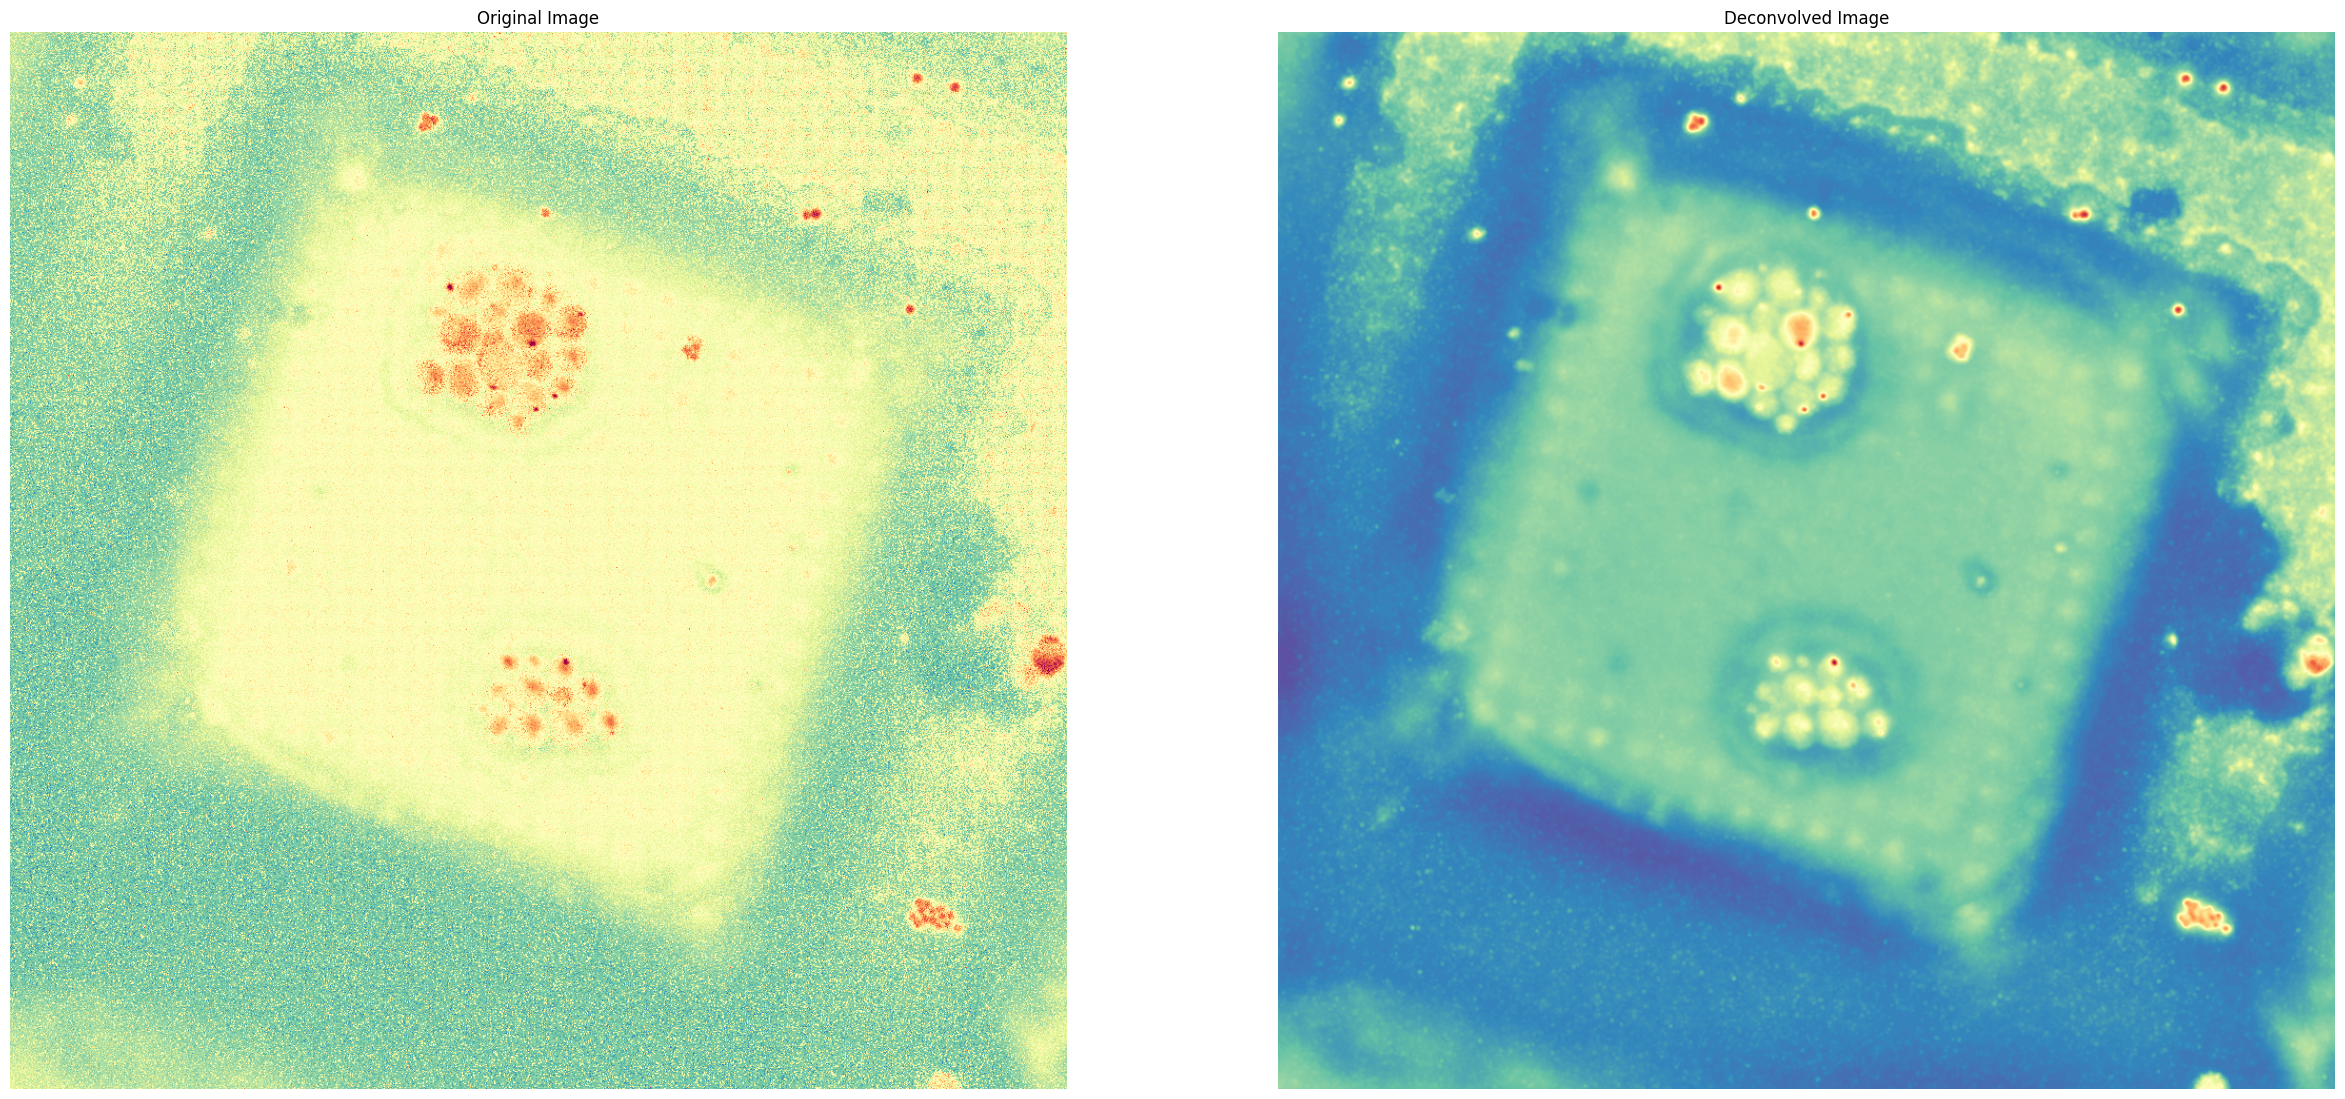

In [ ]:
fig, axs = plt.subplots(1, 2)
axs = axs.ravel()
fig.set_size_inches(30, 15)
center = tuple([slice(None), slice(10, -10), slice(10, -10)])
titles = ['Original Image', 'Deconvolved Image']
for i, d in enumerate([stack_scaled, res.data ]):#res.data
    img = exposure.adjust_gamma(d[center].max(axis=0), gamma=.2)
    axs[i].imshow(img, cmap='Spectral_r')
    axs[i].set_title(titles[i])
    axs[i].axis('off')
    
#pd.DataFrame(scores).T.plot(subplots=True, figsize=(18, 8))

In [ ]:
# Function to plot an image from the stack
def plot_image(i):
    fig,(ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
    ax1.imshow(exposure.adjust_gamma(stack_scaled[i, slice(10, -10), slice(10, -10)], gamma=.2), cmap='gray')#'Spectral_r')
    ax2.imshow(exposure.adjust_gamma(res.data[i, slice(10, -10), slice(10, -10)], gamma=.2), cmap='gray')#'Spectral_r')
    ax2.axis('off')
    fig.show()

# Create a slider widget
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=res.data.shape[0] - 1,
    step=1,
    description='Image Index:',
    continuous_update=True
)


# Create an interactive widget
widgets.interactive(plot_image, i=slider)

interactive(children=(IntSlider(value=0, description='Image Index:', max=85), Output()), _dom_classes=('widget…

IndexError: list index out of range

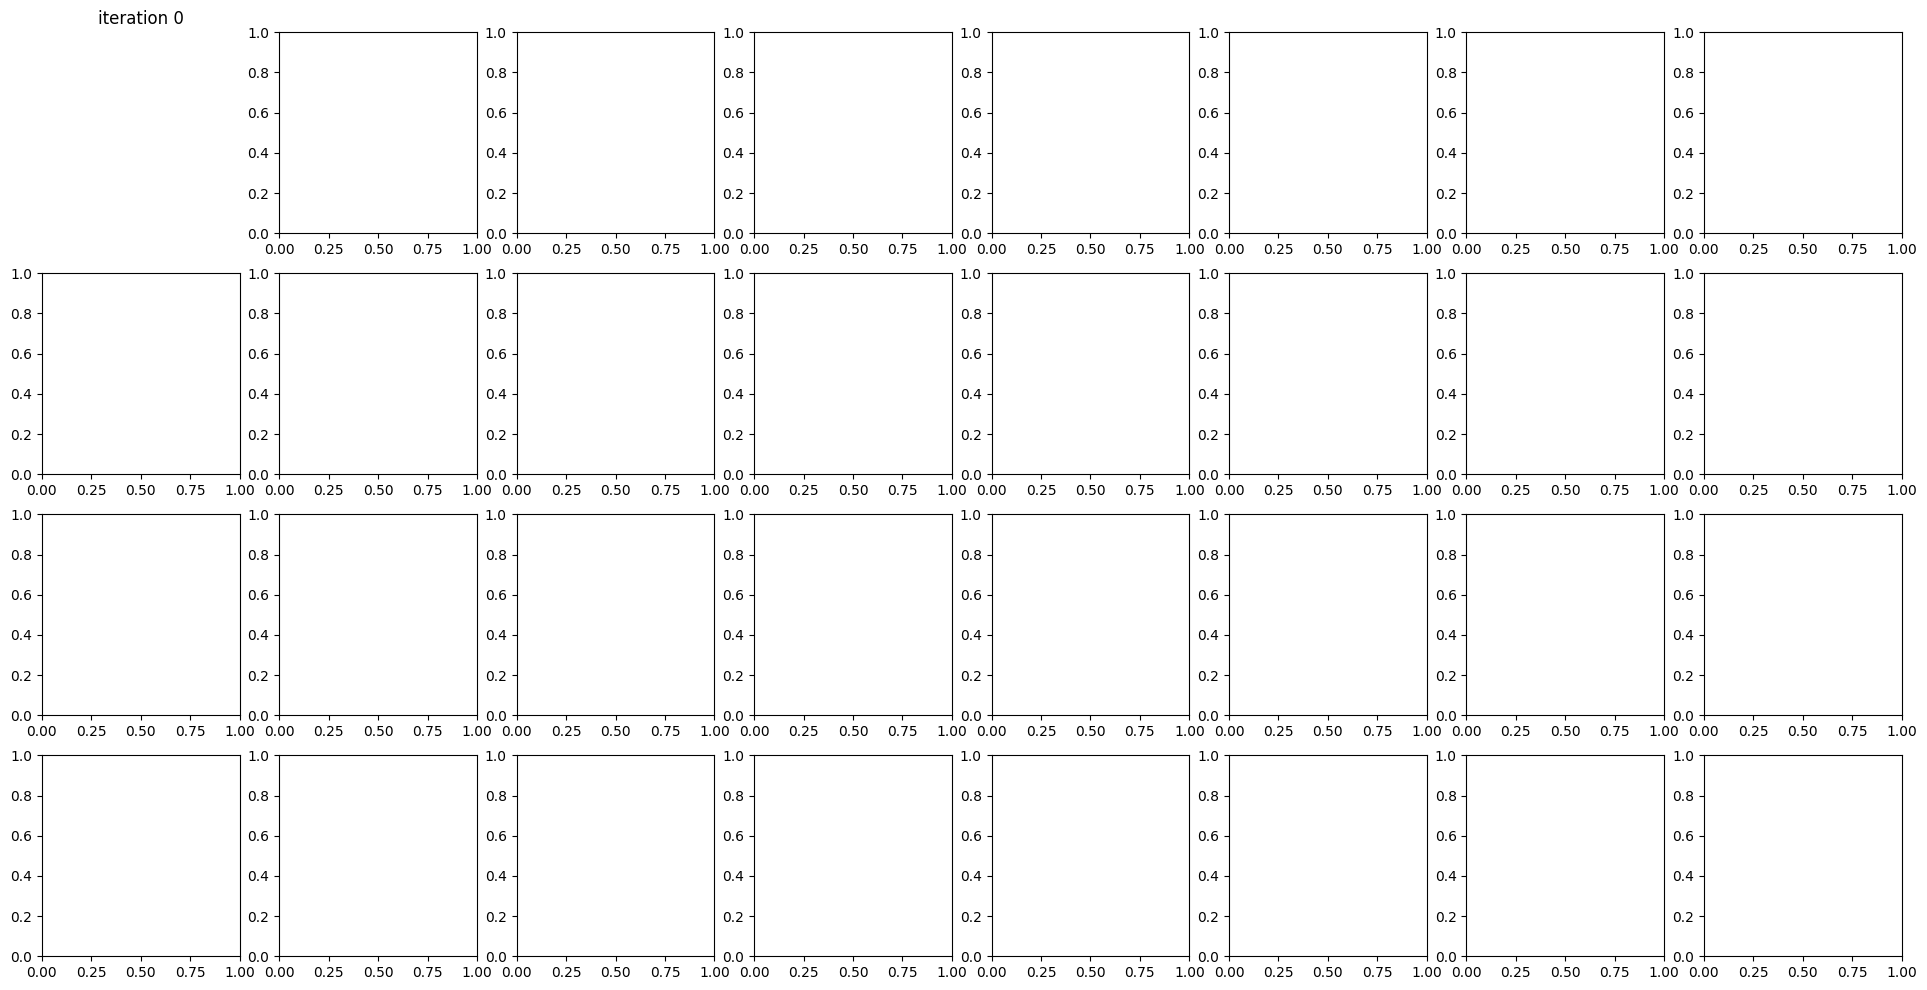

In [ ]:
# Visualize the iterations
n = 32
iters = np.linspace(0, niter-1, num=n).astype(int)
fig, axs = plt.subplots(4, 8)
axs = axs.ravel()
fig.set_size_inches(24, 12)
for i, j in enumerate(iters):
    axs[i].axis('off')
    axs[i].set_title('iteration {}'.format(j))
    axs[i].imshow(imgs[j].max(axis=0))

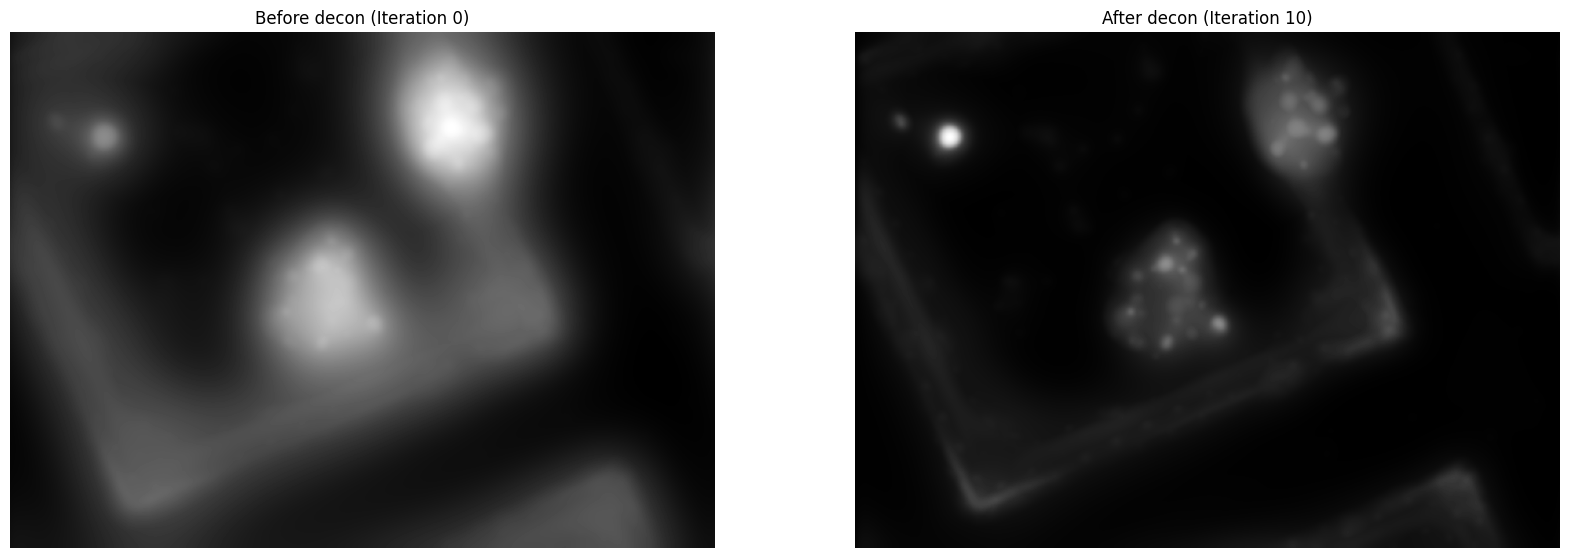

handle_msg[b7317a8da1e84ccebf1e491061a358f9]({'header': {'date': datetime.datetime(2024, 3, 27, 21, 37, 7, 213000, tzinfo=tzutc()), 'msg_id': '4fd5ab75-fe59-4021-a3ca-398bbc3ca61a', 'msg_type': 'comm_msg', 'session': '8e5fddca-4868-4e57-a404-de4cb2bbf7b8', 'username': '97008dd4-fad2-492a-bfa8-da7d89e4a38c', 'version': '5.2'}, 'msg_id': '4fd5ab75-fe59-4021-a3ca-398bbc3ca61a', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': 'b7317a8da1e84ccebf1e491061a358f9', 'data': {'method': 'update', 'state': {'outputs': [{'name': 'stderr', 'text': '/tmp/ipykernel_17324/3982798014.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown\n  fig.show()\n', 'output_type': 'stream'}, {'output_type': 'display_data', 'data': {'text/plain': '<Figure size 2000x1000 with 2 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAABkYAAAIsCAYAAACnaxXSAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/H5lhTAAAACXBIWXMAAA9hAAAPYQG

handle_msg[d3a3a4b86517435f893ea72bf1dd4ba2]({'header': {'date': datetime.datetime(2024, 3, 27, 21, 46, 23, 556000, tzinfo=tzutc()), 'msg_id': '3638bed2-3c95-4ce2-a8b8-c9887d623436', 'msg_type': 'comm_msg', 'session': '8e5fddca-4868-4e57-a404-de4cb2bbf7b8', 'username': '97008dd4-fad2-492a-bfa8-da7d89e4a38c', 'version': '5.2'}, 'msg_id': '3638bed2-3c95-4ce2-a8b8-c9887d623436', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': 'd3a3a4b86517435f893ea72bf1dd4ba2', 'data': {'method': 'update', 'state': {'outputs': [{'name': 'stderr', 'text': '/tmp/ipykernel_19748/3982798014.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown\n  fig.show()\n', 'output_type': 'stream'}, {'output_type': 'display_data', 'data': {'text/plain': '<Figure size 2000x1000 with 2 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAABkYAAAIsCAYAAACnaxXSAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/H5lhTAAAACXBIWXMAAA9hAAAPYQ

handle_msg[ef519b510e9a4b539c32668d4e70f21f]({'header': {'date': datetime.datetime(2024, 3, 27, 22, 39, 2, 68000, tzinfo=tzutc()), 'msg_id': 'ee32bbb6-dee5-4a3f-a556-e30754741b27', 'msg_type': 'comm_msg', 'session': '8e5fddca-4868-4e57-a404-de4cb2bbf7b8', 'username': '97008dd4-fad2-492a-bfa8-da7d89e4a38c', 'version': '5.2'}, 'msg_id': 'ee32bbb6-dee5-4a3f-a556-e30754741b27', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': 'ef519b510e9a4b539c32668d4e70f21f', 'data': {'method': 'update', 'state': {'outputs': [{'name': 'stderr', 'text': '/tmp/ipykernel_29775/3982798014.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown\n  fig.show()\n', 'output_type': 'stream'}, {'output_type': 'display_data', 'data': {'text/plain': '<Figure size 2000x1000 with 2 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAABkYAAAIxCAYAAAAYIwSXAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/H5lhTAAAACXBIWXMAAA9hAAAPYQGo

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 10))
plt.gray()

ax1.axis('off')
ax1.set_title('Before decon (Iteration {})'.format(0))
ax1.imshow(imgs[0].max(axis=0))

ax2.axis('off')
ax2.set_title('After decon (Iteration {})'.format(j+1))
ax2.imshow(imgs[-1].max(axis=0))

In [ ]:
io.imsave('deconv.tif',res.data)
io.imsave('input.tif',stack_scaled)